# Tutorial: Mouse cortex single-cell callingcards data. 

 This is a brd4 single-cell(sc) callingcards dataset in mouse cortex from [Moudgil et al., Cell. (2020)](https://doi.org/10.1016/j.cell.2020.06.037) and it can be downloaded from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE148448).
 
 In this tutorial, we will call peaks, make annotation, do differential peak analysis, and pair peaks with genes. In this dataset, there are 111382 insertions and 35950 cells in total. However, many cells are filtered in scRNA-seq analysis. It uses Mudata for calling cards and RNA data. If you want to use Anndata only, please check [Github](https://nbviewer.org/github/The-Mitra-Lab/pycallingcards_data/blob/main/Mouse_cortex_Example_adata.ipynb)

In [1]:
import pycallingcards as cc
import numpy as np
import pandas as pd
import scanpy as sc
from mudata import MuData

We start by reading qbed data. In this data, one row is one insertion and the columns indicate the chromosome, start point and end point, reads number, the direction, and cell borcode of each insertion. For example, the first row means one insertion is on Chromosome 1, and starts from 3112541 and ends on 3112545. The reads number is 12 with the direction going from 3' to 5'. The barcode of the cell is GATGAAAAGAGTTGGC-1. Note that the barcodes of cells should be consistent with scRNA-seq data.

Use ```cc.rd.read_qbed(filename)``` to read your own qbed data.

In [2]:
qbed_data = cc.datasets.mousecortex_data(data="qbed")
qbed_data 

Chr     Start       End  Reads Direction            Barcodes
0       chr1   3112541   3112545     12         +  GATGAAAAGAGTTGGC-1
1       chr1   3121337   3121341      6         -  CGATCGGCACATTTCT-1
2       chr1   3199281   3199285      7         +  GTCCTCATCTCCGGTT-1
3       chr1   3211433   3211437     22         -  CGAGAAGAGGAATCGC-1
4       chr1   3245859   3245863    149         +  TTTACTGCATCCGCGA-1
...      ...       ...       ...    ...       ...                 ...
111377  chrY  90807968  90807972    200         -  ACGGAGAGTCGCATAT-1
111378  chrY  90833531  90833535     51         -  TAGCCGGTCCTGTACC-1
111379  chrY  90833600  90833604     13         -  TTGGCAAAGAATTGTG-1
111380  chrY  90840262  90840266      8         -  GTGCATAGTACCAGTT-1
111381  chrY  90840262  90840266     95         +  TTGTAGGTCGAATCCA-1

[111382 rows x 6 columns]

Because insertions are discrete, we now need to call peaks to deduce potential binding sites. Three different methods (*CCcaller, cc_tools, Blockify*) are available along with three different species (*hg38, mm10, sacCer3*). 

In this setting, we use ***CCcaller*** in *mouse*('mm10') data. *maxbetween* is the most important parameter for *CCcaller*. It controls the maximum distance between two nearby insertions, or, in another words, the minimum distance between two peaks. 800-2500 is a good parameter for *maxbetween*.  *pvalue_cutoff* is also an important parameter, and a number below 0.05 is strongly advised.

In [3]:
peak_data = cc.pp.call_peaks(qbed_data, method = "CCcaller", reference = "mm10",  maxbetween = 2000, pvalue_cutoff = 0.01,
                  lam_win_size = 1000000,  pseudocounts = 1, record = True, save = 'mouse_cortex.bed')
peak_data

For the CCcaller method without background, [expdata, reference, pvalue_cutoff, lam_win_size, pseudocounts, minlen, extend, maxbetween, test_method, min_insertions, record] would be utilized.


100%|██████████| 21/21 [00:20<00:00,  1.03it/s]


Chr      Start        End  Experiment Insertions  Reference Insertions  \
0     chr1    3399868    3400272                      5                     4   
1     chr1    4806673    4809049                     12                    20   
2     chr1    9300144    9300901                      5                     5   
3     chr1   14302176   14310895                     14                    92   
4     chr1   15287495   15288141                      8                     4   
...    ...        ...        ...                    ...                   ...   
2166  chrX  166172262  166174518                      6                    10   
2167  chrX  166241178  166243587                      8                    18   
2168  chrX  166345453  166350005                     11                    35   
2169  chrX  168117814  168120255                      7                    21   
2170  chrX  169842873  169845831                      9                    28   

      Expected Insertions        pvalue  
0                1.031353  6.965061e-04  
1                1.120541  2.498336e-10  
2                1.037149  7.168254e-04  
3                1.523252  1.015569e-10  
4                1.029800  1.427167e-06  
...                   ...           ...  
2166             1.137755  1.824630e-04  
2167             1.257844  7.050309e-06  
2168             1.507674  7.204418e-08  
2169             1.162110  2.957329e-05  
2170             1.314399  1.292113e-06  

[2171 rows x 7 columns]


In order to choose suitable a method and parameters for peak calling, please take a look at the genome areas. We stongly advise to adjust the parameters for ```cc.pp.callpeaks()``` to call better peaks.

In this plot, the top section is insertions and their read counts. One dot is an insertion and the height is log(reads+1). The middle section is the distribution of insertions. The bottom section represents the reference genes and peaks. 

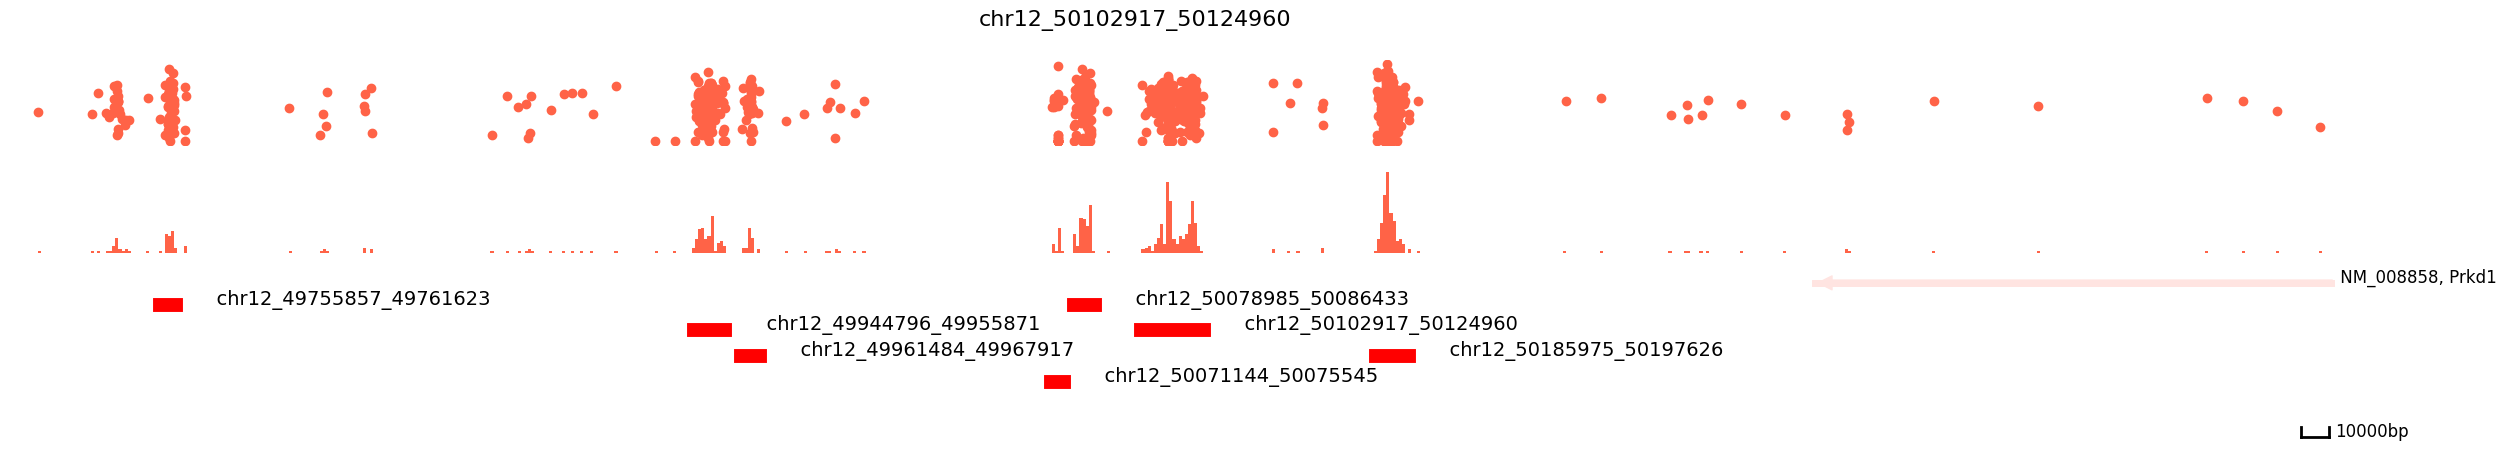

In [4]:
cc.pl.draw_area("chr12",50102917,50124960,400000,peak_data,qbed_data,"mm10",
                figsize = (30,5),peak_line = 4,save = True, title = "chr12_50102917_50124960")

We could also visualize our data in [WashU Epigenome Browser](http://epigenomegateway.wustl.edu/browser/) directly. 
Notice that this link only is valid for 24hrs, so please rerun it if you want to use it.

In [5]:
qbed = {"qbed_data": qbed_data}
bed = {"peak":peak_data}
cc.pl.WashU_browser_url(qbed = qbed,bed = bed,genome = 'mm10')

All qbed addressed
All bed addressed
Uploading files
Please click the following link to see the data on WashU Epigenome Browser directly.
https://epigenomegateway.wustl.edu/browser/?genome=mm10&hub=https://companion.epigenomegateway.org//task/b922f00596db2846384b3cbbef311081/output//datahub.json


We advise to look at the whole chromosome and see the distribution of peaks to make sure everything is going accordingly.

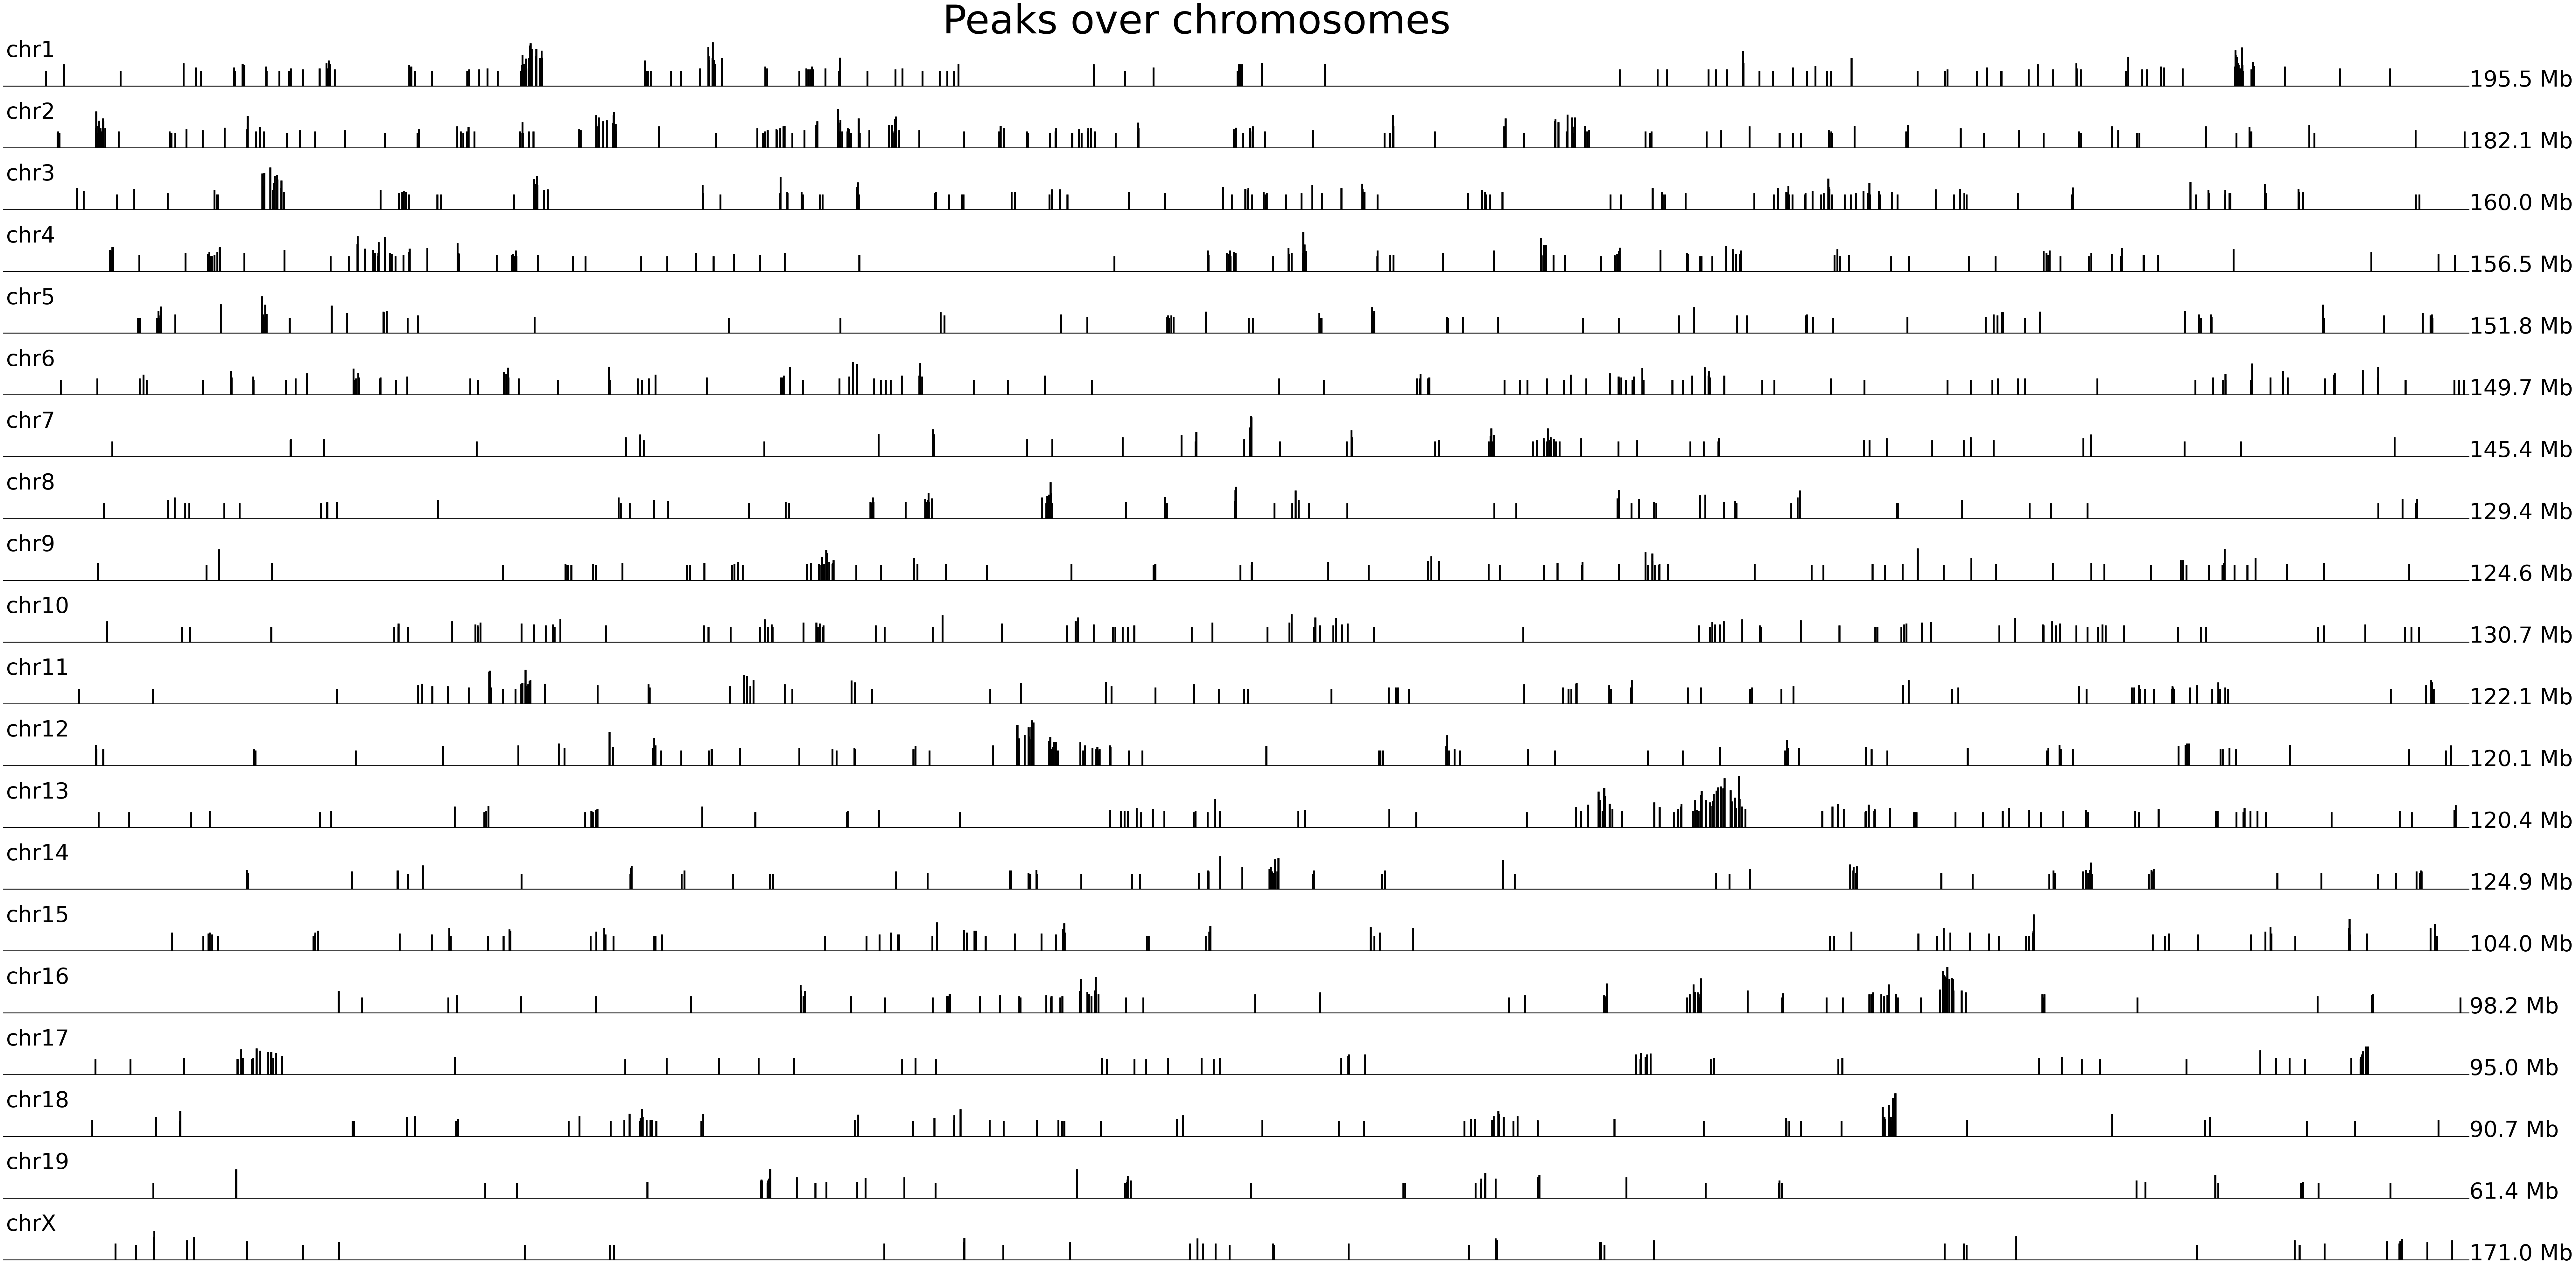

In [6]:
cc.pl.whole_peaks(peak_data, reference = "mm10")

In the next step, we annotate the peaks by their closest genes using [bedtools](https://bedtools.readthedocs.io/en/latest/) and [pybedtools](https://daler.github.io/pybedtools/).
Make sure they are all previously installed before using.

In [7]:
peak_annotation = cc.pp.annotation(peak_data, reference = "mm10")
peak_annotation = cc.pp.combine_annotation(peak_data,peak_annotation)
peak_annotation

In the bedtools method, we would use bedtools in the default path. Set bedtools path by 'bedtools_path' if needed.


Chr      Start        End  Experiment Insertions  Reference Insertions  \
0     chr1    3399868    3400272                      5                     4   
1     chr1    4806673    4809049                     12                    20   
2     chr1    9300144    9300901                      5                     5   
3     chr1   14302176   14310895                     14                    92   
4     chr1   15287495   15288141                      8                     4   
...    ...        ...        ...                    ...                   ...   
2166  chrX  166172262  166174518                      6                    10   
2167  chrX  166241178  166243587                      8                    18   
2168  chrX  166345453  166350005                     11                    35   
2169  chrX  168117814  168120255                      7                    21   
2170  chrX  169842873  169845831                      9                    28   

      Expected Insertions        pvalue Nearest Refseq1 Gene Name1  \
0                1.031353  6.965061e-04    NM_001011874       Xkr4   
1                1.120541  2.498336e-10       NM_008866     Lypla1   
2                1.037149  7.168254e-04    NM_001290390      Sntg1   
3                1.523252  1.015569e-10       NM_010164       Eya1   
4                1.029800  1.427167e-06    NM_001098528      Kcnb2   
...                   ...           ...             ...        ...   
2166             1.137755  1.824630e-04    NM_001310724     Gemin8   
2167             1.257844  7.050309e-06       NM_023122      Gpm6b   
2168             1.507674  7.204418e-08       NM_023122      Gpm6b   
2169             1.162110  2.957329e-05    NM_001290427     Frmpd4   
2170             1.314399  1.292113e-06       NM_010797       Mid1   

     Nearest Refseq2 Gene Name2  
0       NM_001195662        Rp1  
1          NR_033530     Mrpl15  
2          NM_021511       Rrs1  
3          NM_010827        Msc  
4          NM_177781      Trpa1  
...              ...        ...  
2166       NM_023122      Gpm6b  
2167    NM_001310724     Gemin8  
2168       NM_177429       Ofd1  
2169    NM_001290428     Frmpd4  
2170    NM_001290506       Mid1  

[2171 rows x 11 columns]

Then, we read the barcode file.

In [8]:
barcodes = cc.datasets.mousecortex_data(data="barcodes")
barcodes

index
0      AAACCTGAGAACTCGG-1
1      AAACCTGAGCAATCTC-1
2      AAACCTGAGCCGTCGT-1
3      AAACCTGAGTAGCGGT-1
4      AAACCTGAGTGGAGTC-1
...                   ...
35945  TTTGTCAAGTCCCACG-1
35946  TTTGTCACAGCGTCCA-1
35947  TTTGTCACATTTCACT-1
35948  TTTGTCAGTCGCATCG-1
35949  TTTGTCATCTTTACAC-1

[35950 rows x 1 columns]

Use qbed data, peak data and barcode data to make a cell by peak [Anndata](https://anndata.readthedocs.io/en/latest/) object.

In [9]:
adata_cc = cc.pp.make_Anndata(qbed_data, peak_annotation, barcodes)
adata_cc

100%|██████████| 20/20 [00:00<00:00, 61.57it/s]


AnnData object with n_obs × n_vars = 35950 × 2171
    var: 'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

Calling cards data is sequenced along with RNA-seq data. For the following steps, we are going to read scRNA-seq data and analyze them together. [Scanpy](https://scanpy.readthedocs.io/en/stable/) is recommended to load and analyze scRNA-seq data.

In [10]:
adata = cc.datasets.mousecortex_data(data="RNA")
adata

AnnData object with n_obs × n_vars = 30300 × 2638
    obs: 'batch', 'n_genes', 'total_counts', 'cluster'
    var: 'n_counts', 'n_cells', 'highly_variable'

In the scRNA-seq analysis, many cells are filtered out because of low quality. We need to make the cells in qbed anndata to be the exactly same as RNA-seq anndata.

In [11]:
adata_cc = cc.pp.filter_adata_sc(adata_cc,adata)
adata_cc

View of AnnData object with n_obs × n_vars = 30300 × 2171
    var: 'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

In [12]:
mdata = MuData({"RNA": adata, "CC": adata_cc})
mdata

/opt/apps/labs/rmlab/software/juanru/miniconda/lib/python3.9/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/opt/apps/labs/rmlab/software/juanru/miniconda/lib/python3.9/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


MuData object with n_obs × n_vars = 30300 × 4809
  2 modalities
    RNA:	30300 x 2638
      obs:	'batch', 'n_genes', 'total_counts', 'cluster'
      var:	'n_counts', 'n_cells', 'highly_variable'
    CC:	30300 x 2171
      var:	'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

Many results for RNA can be used in calling cards analysis. Here, we borrow clustering information from scRNA-seq data.

Although one peak should have many insertions, but there is a chance that all the cells from the peak were filtered by the RNA preprocesssing. In this case, we advise to filter peaks by the minimum number of cells. 

In [13]:
cc.pp.filter_peaks(mdata["CC"], min_counts=1)

/opt/apps/labs/rmlab/software/juanru/miniconda/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


Differential peak analysis shows significant bindings for each cluster. In this example, we use *binomial test* to find out.

In [14]:
cc.tl.rank_peak_groups_mu(mdata, "RNA:cluster",method = 'binomtest',key_added = 'binomtest')
mdata

100%|██████████| 18/18 [01:21<00:00,  4.55s/it]


MuData object with n_obs × n_vars = 30300 × 4809
  2 modalities
    RNA:	30300 x 2638
      obs:	'batch', 'n_genes', 'total_counts', 'cluster'
      var:	'n_counts', 'n_cells', 'highly_variable'
    CC:	30300 x 2169
      var:	'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2', 'n_counts'
      uns:	'binomtest'

Plot the results for differential peak analysis.

Currently, the peaks are ranked by pvalues. It could also be ranked by logfoldchanges by the following code:

```python
cc.tl.rank_peak_groups_mu(mdata, "RNA:cluster",method = 'binomtest',rankby = 'logfoldchanges')
cc.pl.rank_peak_groups(mdata["CC"], key = 'binomtest',rankby = 'logfoldchanges')

```

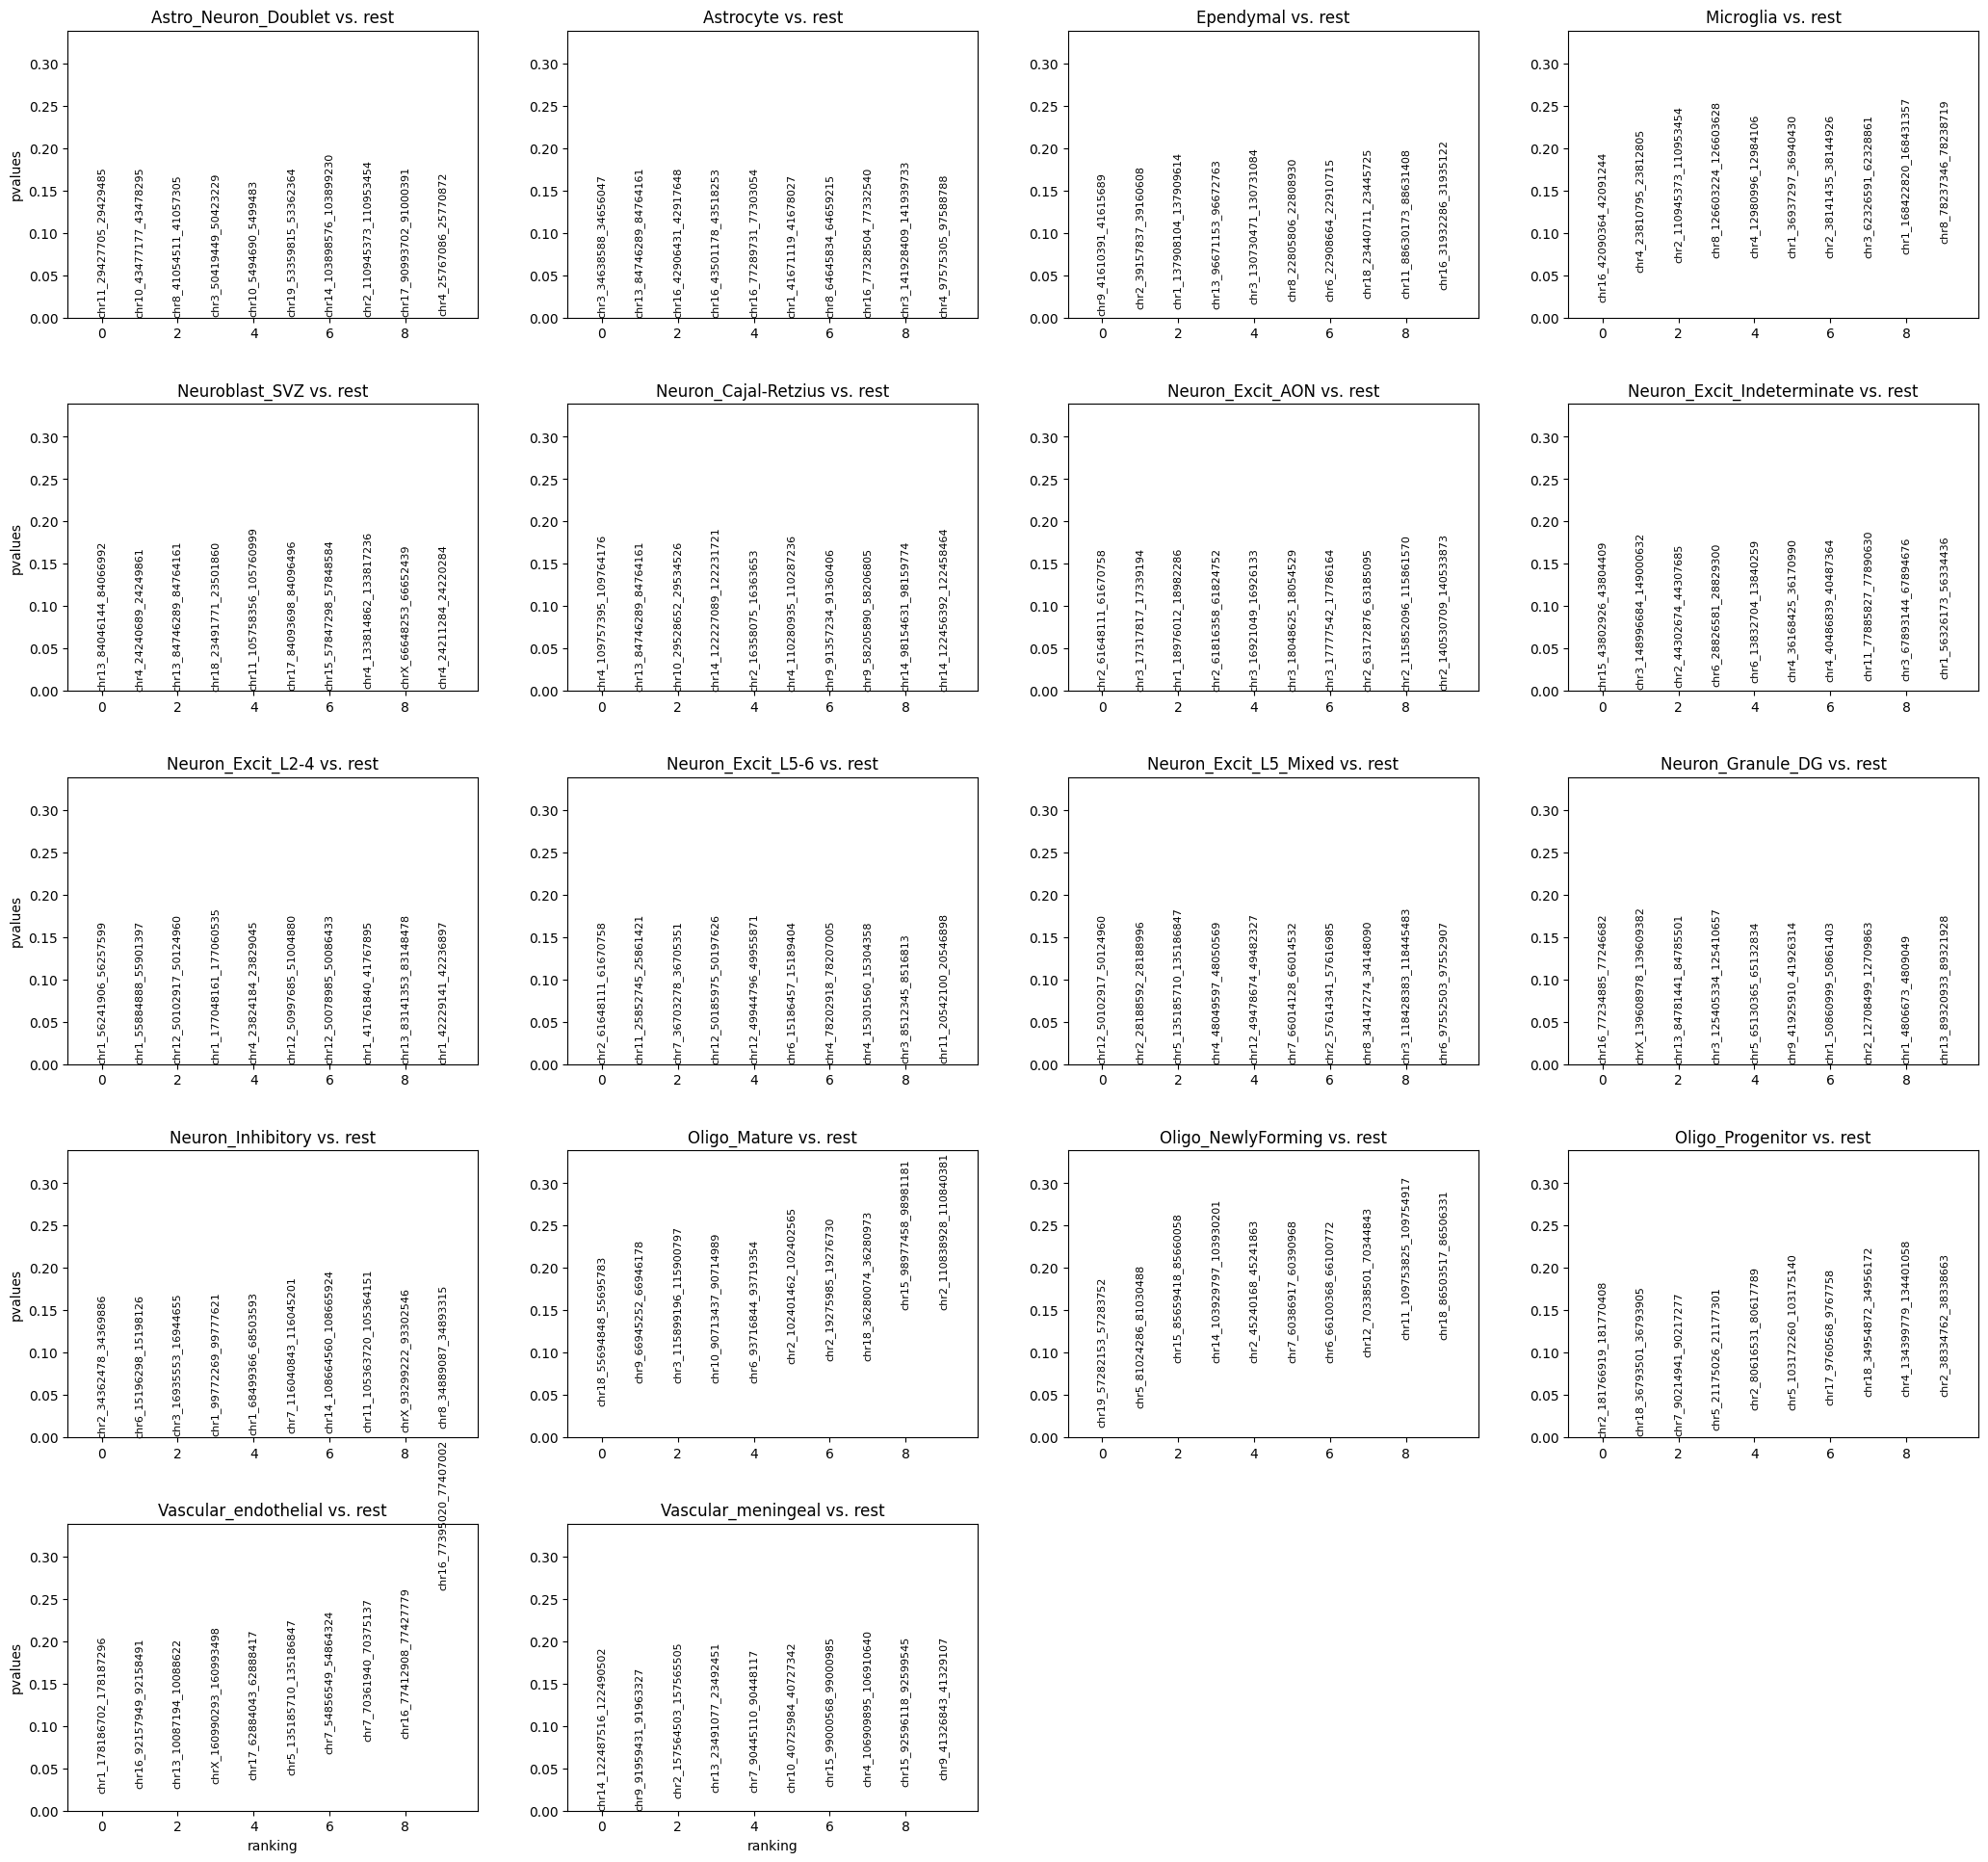

In [15]:
cc.pl.rank_peak_groups(mdata["CC"], key = 'binomtest', save = True)

Then, we take a look at the genome for the highly differentiated peaks. The colored ones are the insertions for a specific cluster and the grey ones are the total insertions for the whole dataset. We can see that most of the insertions are from Astrocyte in the following peaks.

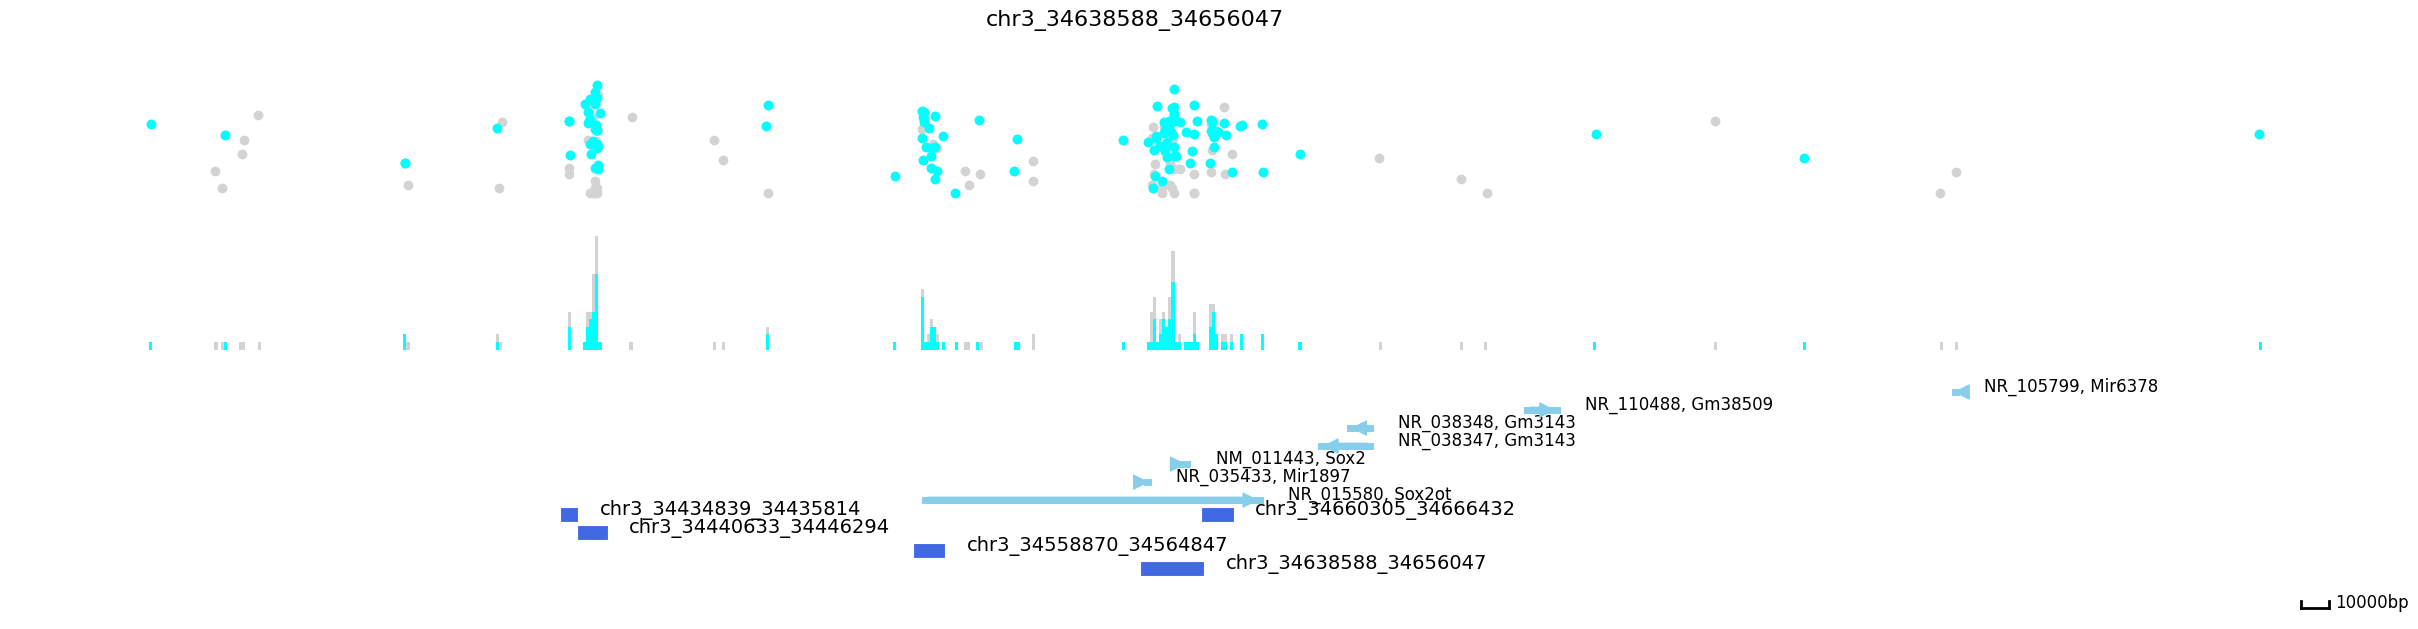

In [16]:
cc.pl.draw_area_mu("chr3",34638588,34656047,400000,peak_data,qbed_data,"mm10",mdata = mdata,
                name = 'Astrocyte',key ='RNA:cluster',figsize = (30,7),peak_line = 4,color = "blue", title = "chr3_34638588_34656047")

If the peak and the related reference genes are also differential, then we can see whether there is a relationship between the binding and gene expression.

Let's do the differential expression analysis for scRNA-seq data.

In [17]:
sc.tl.rank_genes_groups(mdata["RNA"],'cluster')

Find out the co-differential peak-gene pairs. Look into all the differential peaks in each cluster and then see if the annotated genes are significantly expressed in the cluster. We can set the pvalue and score/log foldchange cutoff easily.


In [18]:
cc.tl.pair_peak_gene_sc_mu(mdata, pvalue_cutoff_cc = 0.001, pvalue_cutoff_rna = 0.001, lfc_cutoff = 3, score_cutoff = 3)
mdata["CC"].uns['pair']

Cluster                       Peak  Logfoldchanges  \
0             Astrocyte    chr16_43501178_43518253        3.077262   
1             Astrocyte     chr8_64645834_64659215        4.623955   
2             Astrocyte   chr3_141928409_141939733        4.876938   
3             Astrocyte     chr4_97575305_97588788        3.099679   
4             Astrocyte     chr4_97575305_97588788        3.099679   
..                  ...                        ...             ...   
122   Neuron_Granule_DG    chr13_89320933_89321928        4.399915   
123   Neuron_Inhibitory     chr2_34362478_34369886        3.988165   
124   Neuron_Inhibitory     chr6_15196298_15198126       10.414956   
125  Vascular_meningeal  chr14_122487516_122490502        7.469697   
126  Vascular_meningeal     chr9_91959431_91963327        7.047598   

      Pvalue_peak           Gene  Score_gene    Pvalue_gene  
0    1.462410e-16         Zbtb20   79.234276   0.000000e+00  
1    3.114365e-14          Msmo1   61.964111   0.000000e+00  
2    3.786296e-14         Bmpr1b   24.131538  2.475603e-121  
3    5.907086e-14  E130114P18Rik   16.893749   3.380841e-62  
4    5.907086e-14           Nfia   45.417362   0.000000e+00  
..            ...            ...         ...            ...  
122  7.818271e-04         Hapln1  -14.765965   9.061876e-44  
123  1.977978e-04           Pbx3   15.902434   5.024489e-54  
124  3.822503e-04          Foxp2   20.337471   1.781142e-84  
125  1.026983e-07           Zic2    7.556187   1.062384e-12  
126  3.246923e-04         Plscr1    4.303550   2.515998e-05  

[127 rows x 7 columns]

Draw the results above to find out the potential relationship between TF bindings and gene expression.

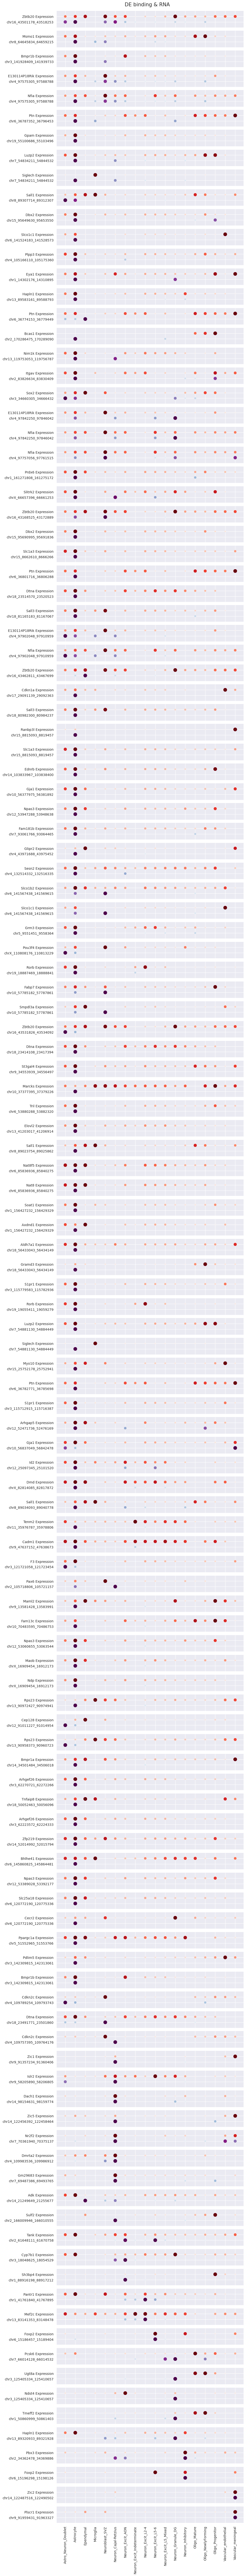

In [19]:
cc.pl.dotplot_sc_mu(mdata)

After seeing the dotplot above, bring some peaks to the RNA Anndata object and see the distribution in the UMAP plot.

In [20]:
sc.pp.pca(mdata["RNA"])
sc.pp.neighbors(mdata["RNA"])
sc.tl.umap(mdata["RNA"])

The first plot is the average insertions of the peak in each cluster, the second plot is the gene expression Gou3f2 (one of its nearest genes for the peak); the third plot is the cluster information.

/opt/apps/labs/rmlab/software/juanru/miniconda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


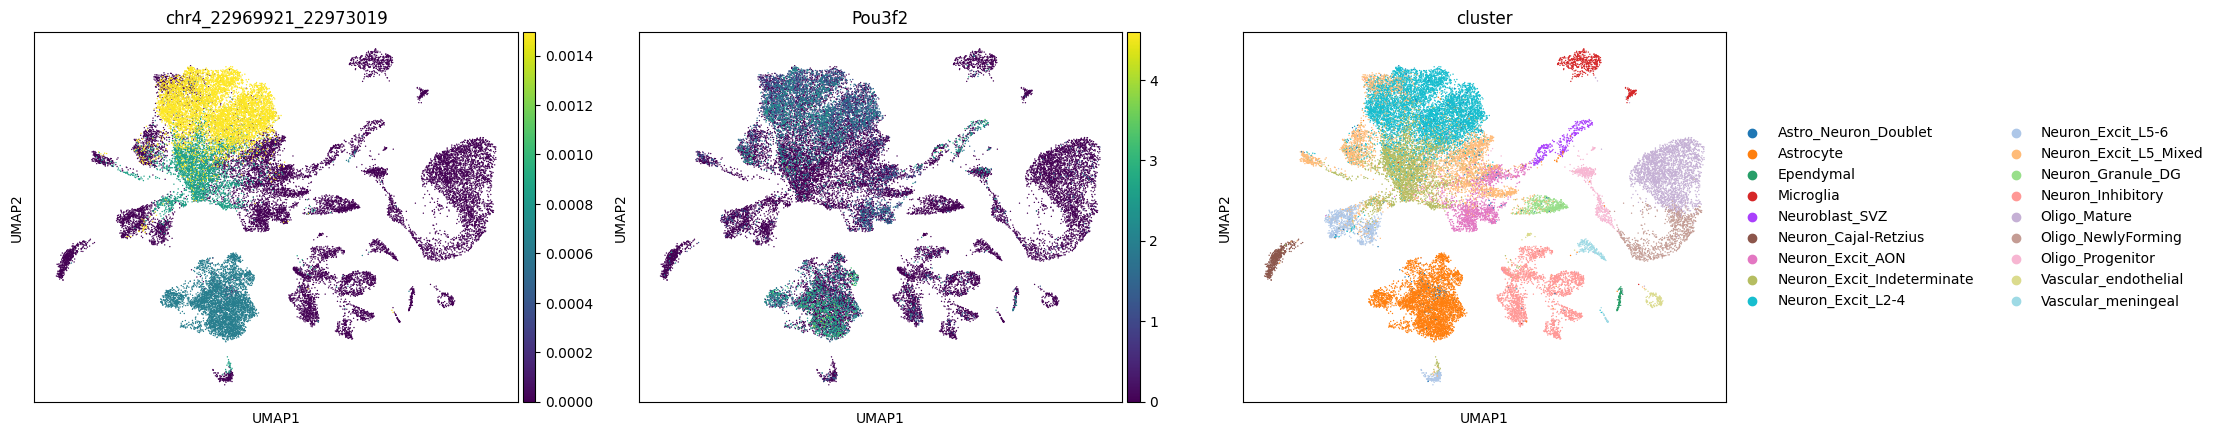

In [21]:
cc.pl.plot_matched(mdata,'chr4_22969921_22973019','Pou3f2')

/opt/apps/labs/rmlab/software/juanru/miniconda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


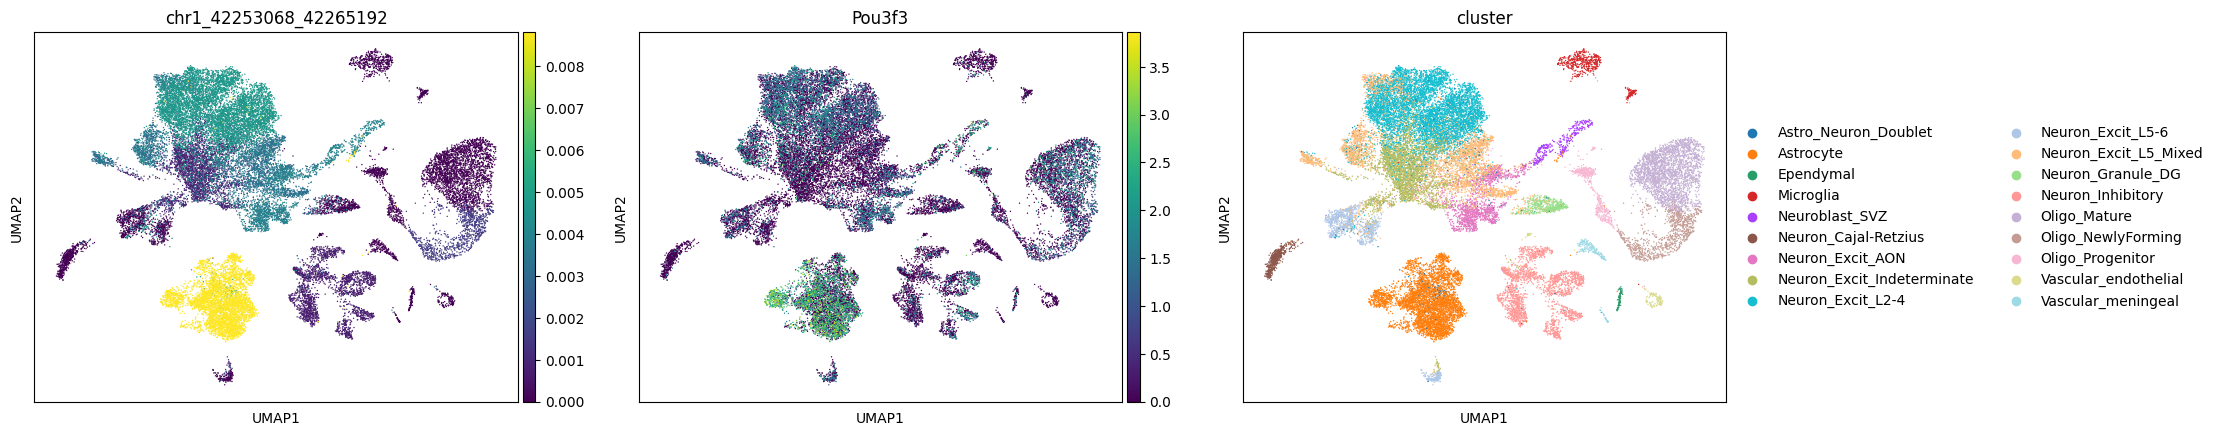

In [22]:
cc.pl.plot_matched(mdata,'chr1_42253068_42265192','Pou3f3')

We can see the potential relationship between bindings and gene expression.

Now, we can make hypotheses in mouse. However, we could try to map the binding sites and genes to the human genome. We use [liftover](https://genome.ucsc.edu/cgi-bin/hgLiftOver) to get the resuls.

In [23]:
mdata["CC"].uns["pair"] = cc.tl.result_mapping(mdata["CC"].uns["pair"])
mdata["CC"].uns["pair"]

Start mapping the peaks to the new genome.


100%|██████████| 127/127 [00:00<00:00, 147.54it/s]


Start finding location of genes in the new genome.


100%|██████████| 127/127 [00:00<00:00, 233.30it/s]


Cluster                       Peak  Logfoldchanges  \
0             Astrocyte    chr16_43501178_43518253        3.077262   
1             Astrocyte     chr8_64645834_64659215        4.623955   
2             Astrocyte   chr3_141928409_141939733        4.876938   
3             Astrocyte     chr4_97575305_97588788        3.099679   
4             Astrocyte     chr4_97575305_97588788        3.099679   
..                  ...                        ...             ...   
122   Neuron_Granule_DG    chr13_89320933_89321928        4.399915   
123   Neuron_Inhibitory     chr2_34362478_34369886        3.988165   
124   Neuron_Inhibitory     chr6_15196298_15198126       10.414956   
125  Vascular_meningeal  chr14_122487516_122490502        7.469697   
126  Vascular_meningeal     chr9_91959431_91963327        7.047598   

      Pvalue_peak           Gene  Score_gene    Pvalue_gene Chr_liftover  \
0    1.462410e-16         Zbtb20   79.234276   0.000000e+00         chr3   
1    3.114365e-14          Msmo1   61.964111   0.000000e+00         chr4   
2    3.786296e-14         Bmpr1b   24.131538  2.475603e-121         chr4   
3    5.907086e-14  E130114P18Rik   16.893749   3.380841e-62         chr1   
4    5.907086e-14           Nfia   45.417362   0.000000e+00         chr1   
..            ...            ...         ...            ...          ...   
122  7.818271e-04         Hapln1  -14.765965   9.061876e-44         chr5   
123  1.977978e-04           Pbx3   15.902434   5.024489e-54         chr9   
124  3.822503e-04          Foxp2   20.337471   1.781142e-84         chr7   
125  1.026983e-07           Zic2    7.556187   1.062384e-12        chr13   
126  3.246923e-04         Plscr1    4.303550   2.515998e-05         chr3   

    Start_liftover End_liftover Chr_hg38 Start_hg38   End_hg38  
0        114439800    114457200     chr3  114314499  115147280  
1        165418445    165438029     chr4  165327665  165343162  
2         95040417     95054959     chr4   94757976   95158450  
3         60858298     60872361                                 
4         60858298     60872361     chr1   61077273   61462788  
..             ...          ...      ...        ...        ...  
122       83941244     83942246     chr5   83638197   83721077  
123      125749576    125757170     chr9  125747337  125967376  
124      114425858    114427606     chr7  114086309  114693772  
125       99994013     99997040    chr13   99981755   99986773  
126      146814700    146818304     chr3  146515179  146544841  

[127 rows x 13 columns]

We search the [GWAS Catalog database](https://www.ebi.ac.uk/gwas/docs/file-downloads) and find out related SNPs in the binding areas.

In [24]:
mdata["CC"].uns["pair"] = cc.tl.GWAS(mdata["CC"].uns["pair"])
mdata["CC"].uns["pair"]

Cluster                       Peak  Logfoldchanges  \
0             Astrocyte    chr16_43501178_43518253        3.077262   
1             Astrocyte     chr8_64645834_64659215        4.623955   
2             Astrocyte   chr3_141928409_141939733        4.876938   
3             Astrocyte     chr4_97575305_97588788        3.099679   
4             Astrocyte     chr4_97575305_97588788        3.099679   
..                  ...                        ...             ...   
122   Neuron_Granule_DG    chr13_89320933_89321928        4.399915   
123   Neuron_Inhibitory     chr2_34362478_34369886        3.988165   
124   Neuron_Inhibitory     chr6_15196298_15198126       10.414956   
125  Vascular_meningeal  chr14_122487516_122490502        7.469697   
126  Vascular_meningeal     chr9_91959431_91963327        7.047598   

      Pvalue_peak           Gene  Score_gene    Pvalue_gene Chr_liftover  \
0    1.462410e-16         Zbtb20   79.234276   0.000000e+00         chr3   
1    3.114365e-14          Msmo1   61.964111   0.000000e+00         chr4   
2    3.786296e-14         Bmpr1b   24.131538  2.475603e-121         chr4   
3    5.907086e-14  E130114P18Rik   16.893749   3.380841e-62         chr1   
4    5.907086e-14           Nfia   45.417362   0.000000e+00         chr1   
..            ...            ...         ...            ...          ...   
122  7.818271e-04         Hapln1  -14.765965   9.061876e-44         chr5   
123  1.977978e-04           Pbx3   15.902434   5.024489e-54         chr9   
124  3.822503e-04          Foxp2   20.337471   1.781142e-84         chr7   
125  1.026983e-07           Zic2    7.556187   1.062384e-12        chr13   
126  3.246923e-04         Plscr1    4.303550   2.515998e-05         chr3   

    Start_liftover End_liftover Chr_hg38 Start_hg38   End_hg38  \
0        114439800    114457200     chr3  114314499  115147280   
1        165418445    165438029     chr4  165327665  165343162   
2         95040417     95054959     chr4   94757976   95158450   
3         60858298     60872361                                  
4         60858298     60872361     chr1   61077273   61462788   
..             ...          ...      ...        ...        ...   
122       83941244     83942246     chr5   83638197   83721077   
123      125749576    125757170     chr9  125747337  125967376   
124      114425858    114427606     chr7  114086309  114693772   
125       99994013     99997040    chr13   99981755   99986773   
126      146814700    146818304     chr3  146515179  146544841   

                                                  GWAS  
0    Schizophrenia; Smoking status (ever vs never s...  
1               Atopic dermatitis (moderate to severe)  
2                                                       
3                                     Refractive error  
4                                     Refractive error  
..                                                 ...  
122                                                     
123  F-strong flavour liking (derived food-liking f...  
124                                                     
125  Hyperopia; Myopia; Ocular disease; Smoking ini...  
126                                                     

[127 rows x 14 columns]

Save the file if needed.

In [25]:
mdata.write("Mouse-Cortex.h5mu")

/opt/apps/labs/rmlab/software/juanru/miniconda/lib/python3.9/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
